<a href="https://colab.research.google.com/github/shakshi12/ACLPUB/blob/master/bigru_w_attention_visualized_for_beginners.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BiGRU w/ Attention visualized for beginners 

This kernel is an attempt at achieving a good trade-off between a pretty simple model and proper results. 

**Attention:** Attention layer is added in top of Bidirectional recurrent layer. At the end of the kernel there is available a visualization of the attention mechanism in order to make it more interpretable and easily understandable.

**Model architecture**
- Embedding layer (GloVe)
- Bidirectional GRU
- Attention layer
- Dense layers

![img](https://i.imgur.com/y0O0FIM.png)

Please, note that this kernel is based on several sources and references, including other kernels, blog posts...

**Sources/References:**

- [A look at different embeddings.! by SRK](https://www.kaggle.com/sudalairajkumar/a-look-at-different-embeddings)
- [Using LSTMs with attention for emotion recognition](https://www.kaggle.com/eray1yildiz/using-lstms-with-attention-for-emotion-recognition)
- [FocalLoss for Keras](https://www.kaggle.com/rejpalcz/focalloss-for-keras)
- [Attention Layer](https://www.kaggle.com/suicaokhoailang/lstm-attention-baseline-0-652-lb)
- [Keras Layer that implements an Attention mechanism for temporal data.](https://gist.github.com/cbaziotis/6428df359af27d58078ca5ed9792bd6d)
- [A Beginner's Guide to Attention Mechanisms and Memory Networks](https://skymind.ai/wiki/attention-mechanism-memory-network)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Imports

In [4]:
# Imports
# Basic
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os, random, math
from sklearn.model_selection import train_test_split
from sklearn import metrics

# DL
import tensorflow as tf
import keras
import keras.backend as K
from keras.callbacks import Callback
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import Model
from keras.layers import Layer, Input, Embedding, Dropout, SpatialDropout1D, GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D, Bidirectional, GRU, CuDNNGRU, Activation, Dense
from keras.layers import Dot, Reshape, TimeDistributed, concatenate, BatchNormalization
from keras import initializers, regularizers, constraints
from tensorflow.keras.optimizers import Adam

# Visualization
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
import seaborn as sns
sns.set()

In [73]:
# Util functions
# Custom F1 callback
sentence_scores = {}

class F1Evaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            y_pred = (y_pred > 0.35).astype(int)
            score = metrics.f1_score(self.y_val, y_pred, average="micro")
            print("\n F1 Score - epoch: %d - score: %.6f \n" % (epoch+1, score))

def make_plot(loss, val_loss, acc, val_acc):
    t = np.arange(1,len(loss)+1,1)

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,3))
    plt.subplots_adjust(wspace=0.2)

    ax1.plot(t, loss)
    ax1.plot(t, val_loss)
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('loss')
    ax1.set_title('Train vs Val loss')
    ax1.legend(['train','val'], ncol=2, loc='upper right')

    ax2.plot(t, acc)
    ax2.plot(t, val_acc)
    ax2.set_xlabel('epoch')
    ax2.set_ylabel('acc')
    ax2.set_title('Train vs Val acc')
    ax2.legend(['train','val'], ncol=2, loc='upper right')

    plt.show();

def rgb_to_hex(rgb):
    return '#%02x%02x%02x' % rgb
    
def attention2color(attention_score):
    r = 255 - int(attention_score * 255)
    color = rgb_to_hex((255, r, r))
    return str(color)

def visualize_attention():
    # Make new model for output predictions and attentions
    model_att = Model(inputs=model.input, \
                            outputs=[model.output, model.get_layer('attention_vec').output])
    idx = np.random.randint(low = 0, high=X_te.shape[0]) # Get a random test
    tokenized_sample = np.trim_zeros(X_te[idx]) # Get the tokenized text
    label_probs, attentions = model_att.predict(X_te[idx:idx+1]) # Perform the prediction

    # Get decoded text and labels
    id2word = dict(map(reversed, tokenizer.word_index.items()))
    decoded_text = [id2word[word] for word in tokenized_sample] 
    
    # Get classification
    label = np.argmax((label_probs>0.5).astype(int).squeeze()) # Only one
    label2id = ['Misleading', 'Non-Misleading']

    # Get word attentions using attention vector
    token_attention_dic = {}
    max_score = 0.0
    min_score = 0.0
    for token, attention_score in zip(decoded_text, attentions[0][-len(tokenized_sample):]):
        token_attention_dic[token] = attention_score
        print('token',  token_attention_dic[token])
        print('attention', attention_score)
        #sentence_scores[token_attention_dic[token]] = attention_score
        

    # Build HTML String to viualize attentions
    html_text = "<hr><p style='font-size: large'><b>Text:  </b>"
    for token, attention in token_attention_dic.items():
        html_text += "<span style='background-color:{};'>{} <span> ".format(attention2color(attention),
                                                                            token)
    #html_text += "</p><br>"
    #html_text += "<p style='font-size: large'><b>Classified as:</b> "
    #html_text += label2id[label] 
    #html_text += "</p>"
    
    # Display text enriched with attention scores 
    display(HTML(html_text))
    
    # PLOT EMOTION SCORES
    
    _labels = ['Misleading', 'Non-Misleading']
    plt.figure(figsize=(5,2))
    plt.bar(np.arange(len(_labels)), label_probs.squeeze(), align='center', alpha=0.5, color=['black', 'red', 'green', 'blue', 'cyan', "purple"])
    plt.xticks(np.arange(len(_labels)), _labels)
    plt.ylabel('Scores')
    plt.show()
    
def under_sample(train_df):
    # UNDER SAMPLE
    insincere = len(train_df[train_df.target == 1])
    insincere_indices = train_df[train_df.target == 1].index

    sincere_indices = train_df[train_df.target == 0].index
    random_indices = np.random.choice(sincere_indices, insincere, replace=False)

    under_sample_indices = np.concatenate([insincere_indices,random_indices])
    under_sample = train_df.loc[under_sample_indices]
    train_df = under_sample.sample(frac=1)
    train_df.info()
    return train_df

def get_coefs(word, *arr): return word, np.asarray(arr, dtype='float32')

def get_embeddings_matrix():
    embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE))

    word_index = tokenizer.word_index
    nb_words = min(MAX_FEATURES, len(word_index))
    print('nb_words: %d' % nb_words)
    embedding_matrix = np.zeros((nb_words, EMB_SIZE))
    print('Embedding matrix shape: %d/%d' % (nb_words, EMB_SIZE))
    for word, i in word_index.items():
        if i >= nb_words: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: embedding_matrix[i] = embedding_vector
    return embedding_matrix

def visualize_attention():
    # Make new model for output predictions and attentions
    '''
    model.get_layer('attention_vec').output:
    attention_vec (Attention)    [(None, 128), (None, 54)] <- We want (None,54) that is the word att
    '''
    model_att = Model(inputs=model.input, \
                            outputs=[model.output, model.get_layer('attention_vec').output[-1]])
    idx = np.random.randint(low = 0, high=X_te.shape[0]) # Get a random test
    tokenized_sample = np.trim_zeros(X_te[idx]) # Get the tokenized text
    label_probs, attentions = model_att.predict(X_te[idx:idx+1]) # Perform the prediction

    # Get decoded text and labels
    id2word = dict(map(reversed, tokenizer.word_index.items()))
    decoded_text = [id2word[word] for word in tokenized_sample] 
    
    # Get classification
    label = (label_probs>0.5).astype(int).squeeze() # Only one
    label2id = ['Misleading', 'Non-Misleading']

    # Get word attentions using attenion vector
    token_attention_dic = {}
    max_score = 0.0
    min_score = 0.0
    
    attentions_text = attentions[0,-len(tokenized_sample):]
    #plt.bar(np.arange(0,len(attentions.squeeze())), attentions.squeeze())
    #plt.show();
    #print(attentions_text)
    attentions_text = (attentions_text - np.min(attentions_text)) / (np.max(attentions_text) - np.min(attentions_text))
    for token, attention_score in zip(decoded_text, attentions_text):
        #print(token, attention_score)
        if (attention_score == np.nan):
          attention_score = 0
        token_attention_dic[token] = attention_score
        print('token',  token)
        print('attention', attention_score)
        if token in sentence_scores:
          sentence_scores[token] = sentence_scores[token] + attention_score
        else:
          sentence_scores[token] = attention_score
        

    # Build HTML String to viualize attentions
    html_text = "<hr><p style='font-size: large'><b>Text:  </b>"
    for token, attention in token_attention_dic.items():
        html_text += "<span style='background-color:{};'>{} <span> ".format(attention2color(attention),
                                                                            token)
    #html_text += "</p><br>"
    #html_text += "<p style='font-size: large'><b>Classified as:</b> "
    #html_text += label2id[label] 
    #html_text += "</p>"
    
    # Display text enriched with attention scores 
    display(HTML(html_text))
    
    # PLOT EMOTION SCORES
    _labels = ['Misleading', 'Non-Misleading']
    probs = np.zeros(2)
    probs[1] = label_probs
    probs[0] = 1- label_probs
    plt.figure(figsize=(5,2))
    plt.bar(np.arange(len(_labels)), probs.squeeze(), align='center', alpha=0.5, color=['black', 'red', 'green', 'blue', 'cyan', "purple"])
    plt.xticks(np.arange(len(_labels)), _labels)
    plt.ylabel('Scores')
    plt.show()

In [60]:
X_te

array([[2, 1, 3, 4, 5],
       [0, 0, 1, 3, 5],
       [0, 0, 8, 1, 9],
       [0, 0, 6, 1, 7]], dtype=int32)

In [74]:
# Util classes
class Attention(Layer):
    def __init__(self,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, return_attention=False,
                 **kwargs):
        self.supports_masking = True
        self.return_attention = return_attention
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias

        super(Attention, self).__init__(**kwargs)


    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight(shape = (input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight(shape = (input_shape[1],),#shape=(self.input_dim, self.units),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        eij = K.squeeze(K.dot(x, K.expand_dims(self.W)), axis=-1)

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        # and this results in NaN's. A workaround is to add a very small positive number ε to the sum.
        # a /= K.cast(K.sum(a, axis=1, keepdims=True), K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        weighted_input = x * K.expand_dims(a)

        result = K.sum(weighted_input, axis=1)

        if self.return_attention:
            return [result, a]
        return result

    def compute_output_shape(self, input_shape):
        if self.return_attention:
            return [(input_shape[0], input_shape[-1]),
                    (input_shape[0], input_shape[1])]
        else:
            return input_shape[0], input_shape[-1]

## Hyperparameters

In [75]:
# Hyperparameters

EMB_SIZE = 300
MAX_FEATURES = 50000 # how many unique words to use (i.e num rows in embedding vector)
MAX_LEN = 100 # Maximum length for texts
EMBEDDING_FILE = '/content/drive/MyDrive/Embeddings/glove.840B.300d.txt'

## Load & prepare data

In [76]:
# Load Train/Test
# initialize data of lists.
data = {'sentences':['niece is a good person', 'trump is a bad person', 'poor is attractive', 'healthy is cool'],
        'label':[0, 1, 1, 0]}
  
# Create DataFrame
df = pd.DataFrame(data)
  
# Print the output.
df
train_df = df
test_df = df
print("Train shape : ",train_df.shape)
print("Test shape : ",test_df.shape)

Train shape :  (4, 2)
Test shape :  (4, 2)


In [77]:
## split to train and val
train_df, val_df = train_test_split(train_df, test_size=0.05, random_state=2018)

## fill up the missing values
X_tra = train_df["sentences"].fillna("_na_").values
X_val = val_df["sentences"].fillna("_na_").values
X_te = test_df["sentences"].fillna("_na_").values

## Tokenize the sentences
tokenizer = Tokenizer(num_words=MAX_FEATURES)
tokenizer.fit_on_texts(list(X_tra))
X_tra = tokenizer.texts_to_sequences(X_tra)
X_val = tokenizer.texts_to_sequences(X_val)
X_te = tokenizer.texts_to_sequences(X_te)

## Pad the sentences 
MAX_LEN = min(MAX_LEN, len(max(X_tra, key=len)))
X_tra = pad_sequences(X_tra, maxlen=MAX_LEN)
X_val = pad_sequences(X_val, maxlen=MAX_LEN)
X_te = pad_sequences(X_te, maxlen=MAX_LEN)

## Get the target values
Y_tra = train_df['label'].values
Y_val = val_df['label'].values

In [78]:
X_te

array([[2, 1, 3, 4, 5],
       [0, 0, 1, 3, 5],
       [0, 0, 8, 1, 9],
       [0, 0, 6, 1, 7]], dtype=int32)

In [10]:
# Load embeddings
embedding_matrix = get_embeddings_matrix()

nb_words: 9
Embedding matrix shape: 9/300


## Model design 

In [79]:
# Define input tensor
inp = Input(shape=(X_tra.shape[1]), dtype='int32')

# Word embedding layer
embedded_inputs = Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1], 
                            weights=[embedding_matrix], trainable = False)(inp)

# Apply dropout to prevent overfitting
embedded_inputs = SpatialDropout1D(0.2)(embedded_inputs)

# Apply Bidirectional GRU over embedded inputs
rnn_outs = Bidirectional(CuDNNGRU(64, return_sequences=True))(embedded_inputs)
rnn_outs = Dropout(0.2)(rnn_outs) # Apply dropout to GRU outputs to prevent overfitting

# Attention Mechanism - Generate attention vectors
sentence, word_scores = Attention(return_attention=True, name = "attention_vec")(rnn_outs)

# Dense layers
fc = Dense(64, activation='relu')(sentence)
fc = Dropout(0.5)(fc)
output = Dense(1, activation='sigmoid')(fc)

# Finally building model
model = Model(inputs=inp, outputs=output)
model.compile(loss='binary_crossentropy', metrics=["accuracy"], optimizer='adam')

# Print model summary
model.summary()

Model: "model_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 5)]               0         
                                                                 
 embedding_6 (Embedding)     (None, 5, 300)            2700      
                                                                 
 spatial_dropout1d_6 (Spatia  (None, 5, 300)           0         
 lDropout1D)                                                     
                                                                 
 bidirectional_6 (Bidirectio  (None, 5, 128)           140544    
 nal)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 5, 128)            0         
                                                                 
 attention_vec (Attention)   [(None, 128),             133

In [80]:
# Train model
F1_Score = F1Evaluation(validation_data=(X_val, Y_val), interval=1)
hist = model.fit(X_tra, Y_tra, validation_data=(X_val, Y_val), 
                 epochs=3, batch_size=1, callbacks=[F1_Score])
val_loss = hist.history['val_loss'];val_acc = hist.history['val_accuracy']
loss = hist.history['loss'];acc = hist.history['accuracy']

Epoch 1/3
1/3 [=========>....................] - ETA: 3s - loss: 0.6773 - accuracy: 1.0000
 F1 Score - epoch: 1 - score: 1.000000 

3/3 [==============================] - 3s 397ms/step - loss: 0.6357 - accuracy: 1.0000 - val_loss: 0.7053 - val_accuracy: 0.0000e+00
Epoch 2/3
1/3 [=========>....................] - ETA: 0s - loss: 0.7821 - accuracy: 0.0000e+00
 F1 Score - epoch: 2 - score: 1.000000 

3/3 [==============================] - 0s 43ms/step - loss: 0.6300 - accuracy: 0.6667 - val_loss: 0.8269 - val_accuracy: 0.0000e+00
Epoch 3/3
1/3 [=========>....................] - ETA: 0s - loss: 0.6485 - accuracy: 1.0000
 F1 Score - epoch: 3 - score: 1.000000 

3/3 [==============================] - 0s 42ms/step - loss: 0.5238 - accuracy: 1.0000 - val_loss: 0.9458 - val_accuracy: 0.0000e+00


## Performance

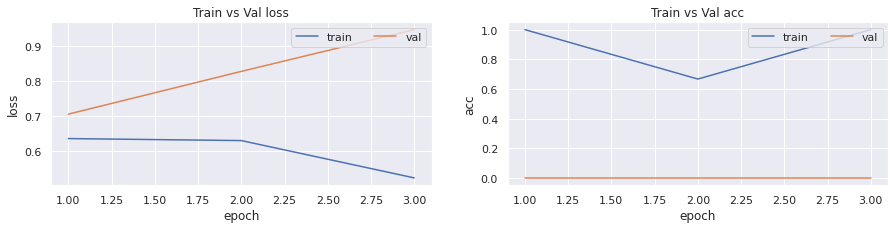

In [81]:
make_plot(loss, val_loss, acc, val_acc)

## Post processing (find best threshold)

In [82]:
val_pred = model.predict([X_val], batch_size=1, verbose=1)
f1s = []
max_thresh, max_f1 = 0, 0
for thresh in np.arange(0.1, 0.9, 0.01):
    f1s.append(metrics.f1_score(Y_val, (val_pred>thresh)))
max_f1 = np.max(f1s)
max_thresh = np.arange(0.1, 0.9, 0.01)[np.argmax(f1s)]
print('Validation set: Max F1-Score: %.2f - reached with threshold: %.2f' % (max_f1, max_thresh))

1/1 [==============================] - 0s 289ms/step
Validation set: Max F1-Score: 1.00 - reached with threshold: 0.10


## Visualize attention

Credit assignment is allocating importance to input features through the weights of the neural network’s model. This is exactly what an attention layer does. 

The attention layer allocates more or less importance to each part of the input, and it learns to do this while training.

In this visualization, the input sentences are displayed. The background colour varies between white and red. More intense red means more attention given to the word.

token poor
attention 1.0
token is
attention 0.0
token attractive
attention 0.1196151


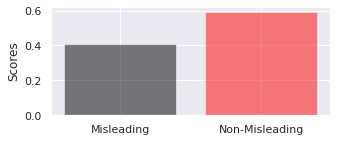

token healthy
attention 0.0
token is
attention 0.07257701
token cool
attention 1.0


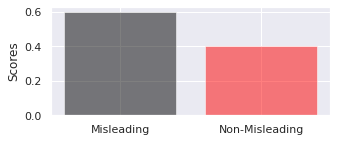

token niece
attention 0.5049102
token is
attention 0.0
token a
attention 0.71677613
token good
attention 0.93914473
token person
attention 1.0


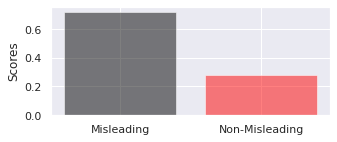

In [83]:
for _ in range(3):
    visualize_attention()

## Predictions over test set

In [84]:
sentence_scores

{'a': 0.71677613,
 'attractive': 0.1196151,
 'cool': 1.0,
 'good': 0.93914473,
 'healthy': 0.0,
 'is': 0.07257701,
 'niece': 0.5049102,
 'person': 1.0,
 'poor': 1.0}

In [18]:
test_pred = model.predict([X_te], batch_size=1024, verbose=1)
test_pred_thresh = (test_pred>max_thresh).astype(int)

1/1 [==============================] - 0s 40ms/step


## Generate submission

In [19]:
out_df = pd.DataFrame({"qid":test_df["qid"].values})
out_df['prediction'] = test_pred_thresh
out_df.to_csv("submission.csv", index=False)
out_df.head()

KeyError: ignored

## Thanks

This is my first kernel ever on Kaggle. If you are still here, thanks :)
    
I hope you find it useful in some way and special thanks to all my sources and references.

- Alber